In [1]:
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_sauvola 
import numpy as np

img = rgb2gray(imread('../sample_images/image1.jpg'))

plt.imshow(img)

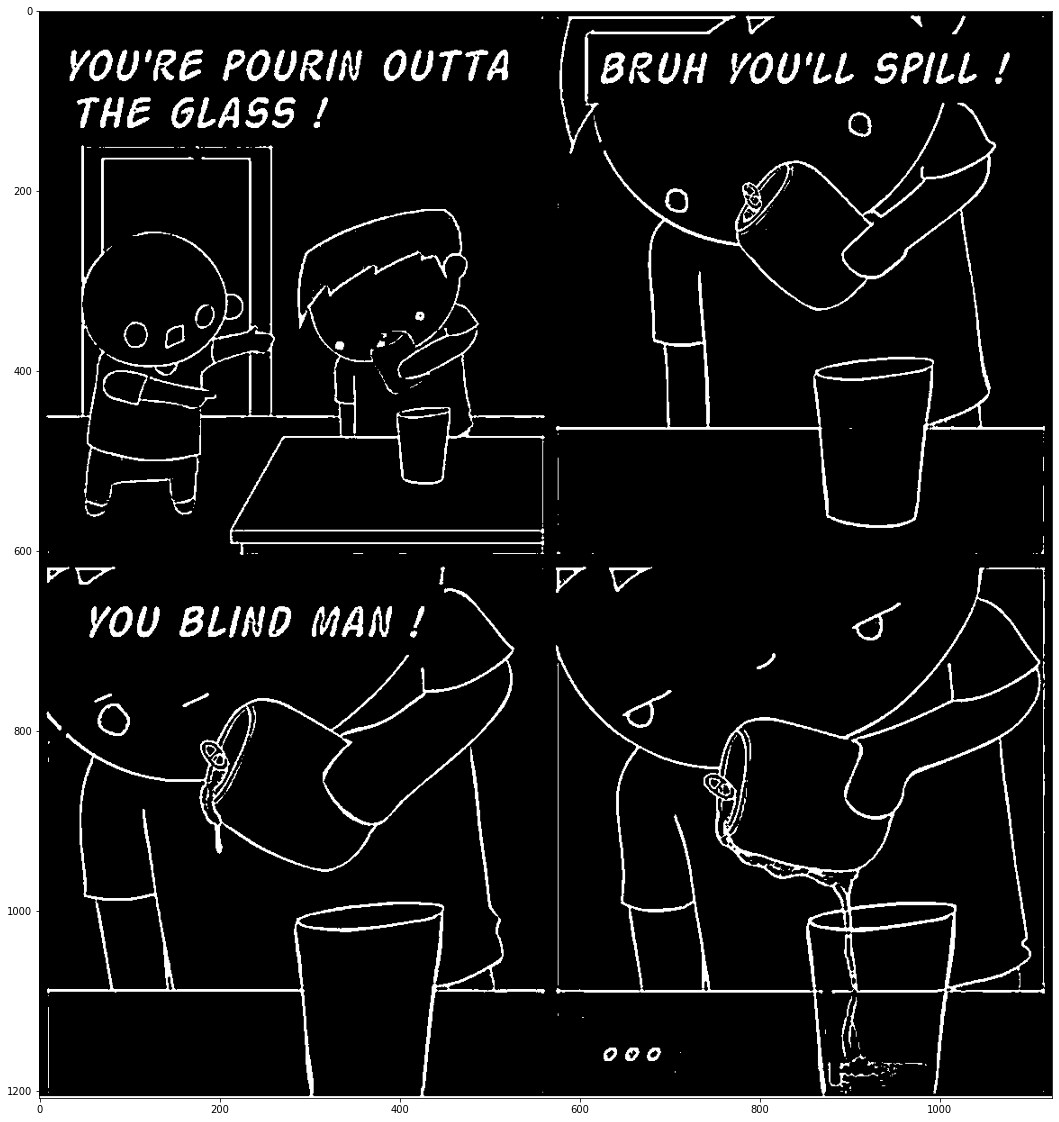

In [2]:
# binarize
from skimage.morphology import binary_closing
window_size = 9
thresh_sauvola = threshold_sauvola(img, window_size=window_size)
binary_sauvola = binary_closing(img < thresh_sauvola)
plt.figure(figsize=(20,20))
plt.imshow(binary_sauvola, cmap="gray")

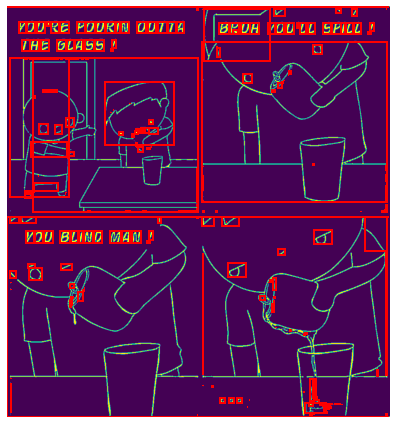

In [3]:
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches

label_image = label(binary_sauvola)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(binary_sauvola)

for region in regionprops(label_image):
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [4]:
def is_a_child(root_region, child_region):
    rminr, rminc, rmaxr, rmaxc = root_region.bbox
    minr, minc, maxr, maxc = child_region.bbox
    if minr > rminr and minc > rminc and maxr < rmaxr and maxc < rmaxc:
        return True
    return False

### Heuristic filter
- 𝐶𝐶𝑠𝑖𝑖𝑧𝑒(𝐶𝐶𝐶𝐶𝑖𝑖) is too low (area of 𝐶𝐶𝐶𝐶𝑖𝑖 less than 6 pixels). With very small size, it is very
difficult for the OCR system to be able to identify, or even for human eyes.
- 𝐼𝑛𝑠(𝐶𝐶𝐶𝐶𝑖𝑖) > 3, 𝐵(𝐶𝐶𝐶𝐶𝑖𝑖) contains many (greater than 3) other bounding boxes. This is
correct not only for English language but also for the Korean or Chinese language.
- 𝐶𝐶𝑑𝑒𝑛𝑠(𝐶𝐶𝐶𝐶𝑖𝑖) is too low (less than 5%). When the density of 𝐶𝐶𝐶𝐶𝑖𝑖 is too low, it can be a
diagonal or noise element (the normal density of text element is greater than 20%)
- 𝐴𝐻𝑊(𝐶𝐶𝐶𝐶𝑖𝑖) <6%, the ratio between the height and the width is not too low or too high,
even though it is the letter “I”

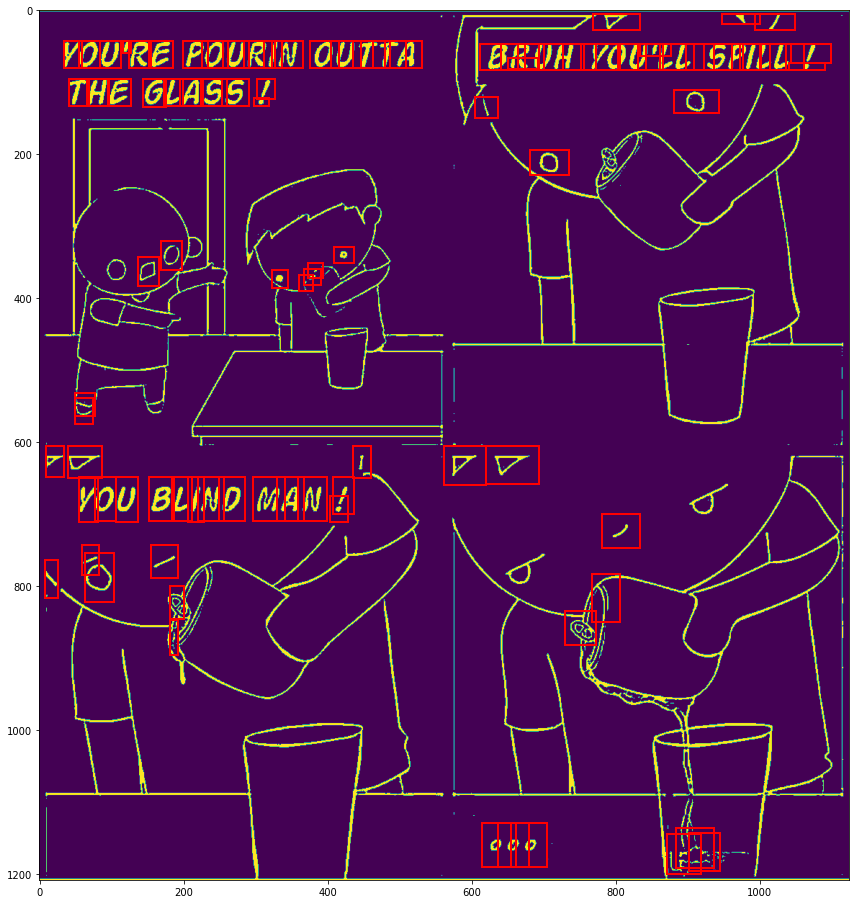

In [5]:
from scipy.ndimage.morphology import distance_transform_edt

region_props = regionprops(label_image)
fig, ax = plt.subplots(figsize=(20, 16))

bounding_boxes = []
# ignore too small areas
for index, region in enumerate(region_props):
    minr, minc, maxr, maxc = region.bbox
    height = maxr - minr
    width = maxc - minc
    
    aspect_ratio = width/height
    
    should_clean = region.area < 15
    should_clean = should_clean or aspect_ratio < 0.06  or aspect_ratio > 3
    should_clean = should_clean or region.eccentricity > 0.995
    should_clean = should_clean or region.solidity < 0.3
    should_clean = should_clean or region.extent < 0.2 or region.extent > 0.9
    should_clean = should_clean or region.euler_number < -4
    
    strokeWidthValues = distance_transform_edt(region.image)
    strokeWidthMetric = np.std(strokeWidthValues)/np.mean(strokeWidthValues)
    should_clean = should_clean or strokeWidthMetric < 0.4
    
#     if should_clean:
#         for coord in region.coords:
#             cleaned_img[coord[0],coord[1]] = False
    if not should_clean:
        # draw rectangle around segmented coins
        expansionAmount = 0.02
        minr, minc, maxr, maxc = region.bbox
        
        minr = int((1-expansionAmount) * minr)
        minc = int((1-expansionAmount) * minc)
        maxr = int((1+expansionAmount) * maxr)
        maxc = int((1+expansionAmount) * maxc)

        bounding_boxes.append([minr, minc, maxr, maxc])
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)    

# remove ccs which have more than 3 components within them
# label_heirarchy = {}
# for iindex, iregion  in enumerate(region_props[0:-1]):
#     count = 0 
#     for jindex, jregion in enumerate(region_props[1:]):
#         if is_a_child(iregion, jregion):
#             count += 1

#     if count < 3:
#         minr, minc, maxr, maxc = iregion.bbox
#         bounding_boxes.append([minr, minc, maxr, maxc])

ax.imshow(binary_sauvola)
plt.show()

True


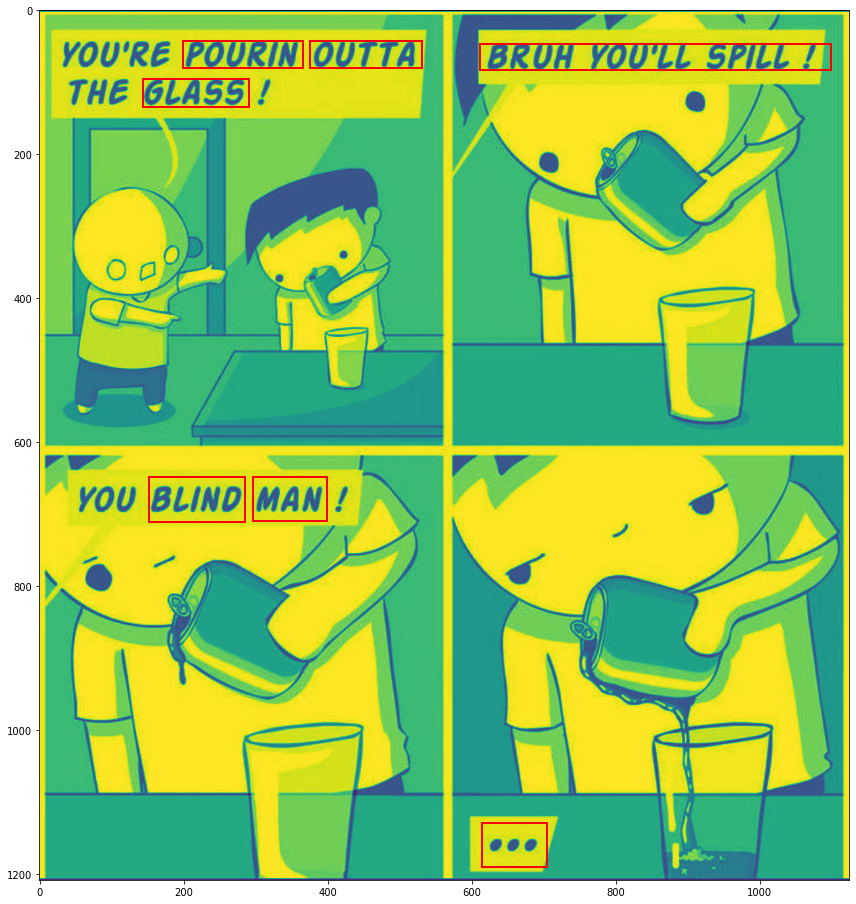

In [6]:
# https://stackoverflow.com/questions/306316/determine-if-two-rectangles-overlap-each-other

# minr, minc, maxr, maxc
def is_overlapping(box1, box2):
#     if (RectA.minc < RectB.maxc && RectA.maxc > RectB.minc &&
#      RectA.minr > RectB.maxr && RectA.maxr < RectB.minr )
    if box1[1] < box2[3] and box1[3] > box2[1] and box1[0] < box2[2] and box1[2] > box2[0]:
        return True
    return False

def is_almost_in_line(box1, box2):
    centroid_b1 = [int((box1[0]+box1[2])/2), int((box1[1]+box1[3])/2)]
    centroid_b2 = [int((box2[0]+box2[2])/2), int((box2[1]+box2[3])/2)]
    if centroid_b2[0]-centroid_b1[0] == 0:
        return True
    
    angle = (np.arctan(np.abs((centroid_b2[1]-centroid_b1[1])/(centroid_b2[0]-centroid_b1[0])) )*180)/np.pi
    #print(angle)
    if angle > 70:
        return True
    
    return False

#print(is_overlapping([1,1,3,3],[2,2,4,4]))
def combine_boxes(box1, box2):
    minr = np.min([box1[0],box2[0]])
    minc = np.min([box1[1],box2[1]])
    maxr = np.max([box1[2],box2[2]])
    maxc = np.max([box1[3],box2[3]])
    return [minr, minc, maxr, maxc]

#print(combine_boxes([1,1,3,3],[2,2,4,4]))
#combine overlapping boxes

# sort the bounding_boxes by their distance from Y Axis
bounding_boxes = np.array(bounding_boxes)
bounding_boxes = bounding_boxes[bounding_boxes[:,1].argsort()]

def groups_the_bounding_boxes(bounding_boxes):
    grouped = []
    box_groups = []
    for iindex, box1 in enumerate(bounding_boxes):
        if iindex in grouped:
            continue

        bigger_box = box1
        group_size = 0
        for jindex, box2 in enumerate(bounding_boxes):
            if jindex in grouped:
                continue

            if iindex != jindex and is_overlapping(bigger_box,box2) and is_almost_in_line(bigger_box, box2): # and is_almost_in_line(bigger_box, box2):
                #print(is_almost_in_line(bigger_box, box2))
                bigger_box = combine_boxes(bigger_box, box2)
               
                grouped.append(iindex) # gets added multiple times. TODO.
                grouped.append(jindex)
                group_size += 1

        if group_size > 1:
            box_groups.append(bigger_box)
            
    return box_groups

box_groups = groups_the_bounding_boxes(bounding_boxes)

fig, ax = plt.subplots(figsize=(20, 16))

# minr, minc, maxr, maxc
for box in box_groups:
    minr = box[0]
    minc = box[1]
    maxr = box[2]
    maxc = box[3]
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)  

ax.add_patch(rect)  
ax.imshow(img)
plt.show()